In [1]:
import numpy as np
import tensorflow as tf

import os 
from os import path
import glob
import imageio

from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt

In [2]:
# Samples taken from dataset at: https://github.com/yinhaoz/denoising-fluorescence

# Each sample is reflected to create 3 samples: the original, reflection about y-axis, 
# and reflection about x-axis. 
# Each of these 3 samples are rotated to generate the desired number of images per sample.

In [3]:
# Names of sample files: sample_names-xxxxx
samples_dir = path.join('..', '..', 'data', '2d_data', 'real_data', 'denoising_dataset')
sample_files = glob.glob(path.join(samples_dir, '*', 'gt', '*', '*.png'))

record_dir = path.join('..', '..', 'data', '2d_data', 'tf_records', 'dataset_1', 'ground_truths')

# Target number of images per image, should be divisible by 3.
num_images_per = 51
obj_dims = (648, 486)

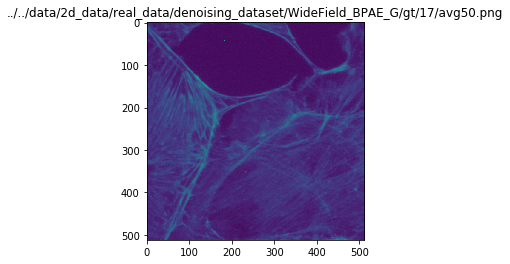

In [4]:
# Visualize a sample 
im = imageio.imread(sample_files[0])
fig = plt.figure()
plt.title(sample_files[0])
plt.imshow(im)
plt.show()

In [5]:
print(im.shape)

(512, 512)


# Helper Functions

In [6]:
def normalize(im):
    """
    Normalizes im from 0 to 1.
    """
    im_max = np.max(im)
    im_min = np.min(im)
    return (im - im_min) / (im_max - im_min)

def calc_resize_width(target_dims):
    """
    Calculates and returns resize width necessary so that rotated image spans entire image.
    """
    # Height/width of im must equal diagonal of target_dims
    return int(np.sqrt(np.square(target_dims[0]) + np.square(target_dims[1])))

def crop(im, target_dims):
    """
    Crops image numpy array to target dims (y, x), centering image. 
    Returns cropped image.
    """
    y1, x1 = im.shape
    y2, x2, = target_dims
    y_diff, x_diff = y1 - y2, x1 - x2
    c_y1, c_y2 = int(np.ceil(y_diff / 2)), y1 - int(np.floor(y_diff / 2))
    c_x1, c_x2 = int(np.ceil(x_diff / 2)), x1 - int(np.floor(x_diff / 2))
                    
    return im[c_y1:c_y2, c_x1:c_x2]

def augment(im, target_dims, num_degrees, transform=None):
    """
    Takes in numpy array. First, doubles the size of the image. 
    Then pads image with zeroes such that rotation fits in the image.
    Uses PIL to apply transform and rotation. Crops the image back to be of obj_target_dims size.
    Returns resulting numpy array.
    
    Arguments:
        - im: image to be transformed
        - num_degrees: number of degrees to rotate
        - target_dims: target image size (y, x).
        - transform: transform to be applied before rotation
            - 'flip': reflects along x-axis
            - 'mirror': reflects along y-axis
    """
    
    im = Image.fromarray(im)
    size = calc_resize_width(target_dims)
    im = im.resize((size, size))
    if transform == 'flip':
        im = ImageOps.flip(im)
    elif transform == 'mirror':
        im = ImageOps.mirror(im)
    im = im.rotate(num_degrees)
    im = np.asarray(im)
    im = crop(im, target_dims)
    
    return im

def _create_example(plane):
    """
    Creates and returns tf.Example from a given numpy array.
    """
    plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
    feature = {
        'plane': plane_feature
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Data Augmentation

In [ ]:
num_rotations = num_images_per // 3
degree_increment = 360 / num_rotations

for i in range(len(sample_files)):
    
    # Read in and normalize
    sample_file = sample_files[i]
    sample = imageio.imread(sample_file)
    sample = normalize(sample)
    assert (np.max(sample) == 1 and np.min(sample) == 0)
    
    # Perform rotation for each flipping/mirroring. Write to file.
    for j in range(num_rotations):
        num_degrees = degree_increment * j
        
        sample_aug = augment(sample, obj_dims, num_degrees, transform=None)
        sample_names = sample_file.split(os.sep)
        sample_name = '{0}_{1}_{2}'.format(sample_names[-4], sample_names[-3], sample_names[-2])
        record_file = path.join(record_dir, sample_name+ '-%.5d' % (num_images_per*i + 3*j) + '.tfrecord')
        
        with tf.io.TFRecordWriter(record_file) as writer:
            tf_example = _create_example(sample_aug)
            writer.write(tf_example.SerializeToString())
            
#         plt.imshow(sample_aug)
#         plt.title('i: {0}, num_degrees: {1}, transform: {2}'.format(i, num_degrees, 'None'))
#         plt.show()
        
        sample_aug = augment(sample, obj_dims, num_degrees, transform='flip')
        sample_names = sample_file.split(os.sep)
        sample_name = '{0}_{1}_{2}'.format(sample_names[-4], sample_names[-3], sample_names[-2])
        record_file = path.join(record_dir, sample_name+ '-%.5d' % (num_images_per*i + 3*j + 1) + '.tfrecord')
        with tf.io.TFRecordWriter(record_file) as writer:
            tf_example = _create_example(sample_aug)
            writer.write(tf_example.SerializeToString())
            
#         plt.imshow(sample_aug)
#         plt.title('i: {0}, num_degrees: {1}, transform: {2}'.format(i, num_degrees, 'flip'))
#         plt.show()
        
        sample_aug = augment(sample, obj_dims, num_degrees, transform='mirror')
        sample_names = sample_file.split(os.sep)
        sample_name = '{0}_{1}_{2}'.format(sample_names[-4], sample_names[-3], sample_names[-2])
        record_file = path.join(record_dir, sample_name+ '-%.5d' % (num_images_per*i + 3*j + 2) + '.tfrecord')
        with tf.io.TFRecordWriter(record_file) as writer:
            tf_example = _create_example(sample_aug)
            writer.write(tf_example.SerializeToString())
            
#         plt.imshow(sample_aug)
#         plt.title('i: {0}, num_degrees: {1}, transform: {2}'.format(i, num_degrees, 'mirror'))
#         plt.show()
        

# Original Data (without augmentation)

In [7]:
# Original samples only (240 images only)
for i in range(len(sample_files)):
    
    # Read in and normalize
    sample_file = sample_files[i]
    sample = imageio.imread(sample_file)
    sample = normalize(sample)
    assert (np.max(sample) == 1 and np.min(sample) == 0)

    sample_aug = augment(sample, obj_dims, num_degrees=0, transform=None)
    sample_names = sample_file.split(os.sep)
    sample_name = '{0}_{1}_{2}'.format(sample_names[-4], sample_names[-3], sample_names[-2])
    record_file = path.join(record_dir, sample_name+ '-%.5d' % i + '.tfrecord')
    
    with tf.io.TFRecordWriter(record_file) as writer:
        tf_example = _create_example(sample_aug)
        writer.write(tf_example.SerializeToString())